# Evaluating How Liberal vs. Conservative Opinion News Shows Influenced the Narrative about the COVID-19 Pandemic

**Group Members: Jennifer Andre, Tobi Jegede, Callie Lambert, & Lori Zakalik**

**Date**: May 2, 2022

**Disclaimer:** The runtime for our notebook is approximately **INSERT TIME HERE** minutes/hours. In order to run our team's notebook, please make sure you have the following python libraries and packages downloaded on your device:
* glob
* os
* matplotlib.pyplot
* numpy
* string
* regex
* sklearn.feature_extraction
* operator
* collections
* spacy
* sklearn.decomposition
* wordcloud
* ntlk.sentiment
    *  Note: If you run into issues after downloading the above package (ntlk.sentiment), please use the code chunk below: 
    
        ```python
        import nltk 
        import ssl
        try: 
            _create_unverified_https_context = ssl._create_unverified_context
        except AttributeError:
            pass
        else:
            ssl._create_default_https_context = _create_unverified_https_context 
            
        nltk.download('vader_lexicon')
        ```

## Explanation of the Data

As mentioned in our Final Project Proposal, we wanted to specifically analyze how the different **opinion** news arms of popular cable news channels talked about the COVID-19 pandemic. 

Using some research from the Pew Research Center, we found that CNN and MSNBC were the most popular news channels watched by individuals who consistently voted for liberal political candidates, while Fox News was the most watched cable news channel for individuals who consistently voted for conservaive political candidates. 

We then found additional articles that provided information on the most watched tv shows on CNN, MSNBC, and Fox News and found that Anderson Cooper 360 was the most watched show on CNN, Rachel Maddow was the most watched show on MSNBC, and Tucker Carlson and the Five were the most watched shows on Fox News. 

We then used webscraping techniques to pull the text files for the transcripts for each of the shows mentioned above from March 2020 to March 2022. The code to run this webscraping can be found in the code folder on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp 



# Setup & Data Pre-Processing 

In [2]:
#import packages & libraries
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import string
import regex as re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
from collections import Counter
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from matplotlib.ticker import PercentFormatter


## Load Data

**Disclaimer:** You may need to adjust the code chunk below to properly load in the data. Our current file structure is:
- Code Repository Folder (opinion-news-nlp)
    - data
        - 01-raw
            - name of opinion news show
                - a list of text files

In [3]:

#get the correct file path starting file path
repo_path = os.path.dirname(os.getcwd()) 

#read in the liberal corpus
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files
all_liberal_files = rm_paths + ac_paths # all liberal trasncripts

#read in the conservative corpus 
tc_paths = glob.glob(repo_path + "/data/01-raw/tucker_carlson/*.txt") #the paths for the tucker carlson transcript files
tf_paths = glob.glob(repo_path + '/data/01-raw/the_five/*.txt') #the paths for the five transcript files
all_conservative_files = tc_paths + tf_paths #all conservative transcripts

#read in the CDC transcripts
cdc_paths = glob.glob(repo_path + "/data/01-raw/cdc_press_releases/*.txt") #the paths for cdc transcript files


The basic summary statistics for all of the data that we used in our analysis is as follows:
1. Conservative Corpus, N = 458
    - Tucker Carlson, 208
    - The Five, 250
2. Liberal Corpus, N = 1,008
    - Anderson Cooper, 530
    - Rachel Maddow, 478
3. CDC, N = 47


It is important to note that there are fewer conservative transcripts in the corpus. Fox News does not have transcripts available for every show (e.g., Tucker Carlson airs every weeknight, but there are only transcripts available for 1-2 shows per week). Although this a limitation, the conservative corpus still provided a large amount of unstructured data to compare against the liberal corpus. <<*add info about script length*>>

## Define COVID Terms

In the below, we created lists of words to use to help with co-occurrence analysis later on in our notebook. We specifically wanted to catalog most of the ways that COVID, mask, and vaccine words could potentially show up in the transcripts in the dataset.

In [4]:
# covid terms
#covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 'covid19', 'virus']

covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 
                'covid19', 'virus', 'sars', 'sars-', 'sars-cov-2']

In [5]:
# vaccine terms
#vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 'vaxxed']

vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 
                'vaxxed', 'pfizer', 'moderna', 'johnson', 'j&j']



In [6]:
# mask terms
#mask_terms = ['mask', 'masking']

mask_terms = ['mask', 'masking', 'n95', 'kn95']

In [7]:
# other COVID-related terms (can choose to use or not)
other_terms = ['china', 'wuhan', 'mandate', 'pandemic', 'epidemic', 'virus',
                'distancing', 'spread', 'immunity', 'incubation', 'quarantine']

all_covid_terms = covid_terms + other_terms

## Update Stop Words

In the code chunk below, we add specific stop words for the conservative, liberal, and CDC news sources in order to remove named entities, like the names of the talk show hosts, as well as the name of the CDC, from the list of relevant words to count.

In [8]:
# add network, host names for conservative news corpus
add_stop_words_conservative = ['tucker', 'carlson', 'fox', 'news', 'five', 
                'greg', 'gutfeld', 'dana', 'perino', 'jesse', 'watters', 
                'jeanine', 'pirro', 'geraldo', 'rivera', 'jessica', 'tarlov',
                'harold', 'ford', 'jr', 'ok', 'williams',  'pavlich', 'fauci', 'faucis'
                'mcdowell', 'juan', 'thanks', 'crosstalk', 'unidentified',
                 'video', 'clip', 'voiceover', 'videotape']

# add host names, important figures for the liberal news corpus
add_stop_words_liberal = ['anderson', 'cooper', 'rachel', 'maddow', 
                  'chris', 'hayes', 'ari', 'berman', 'michael', 'osterholm',
                  'cnn', 'msnbc', 'cnns', 'msnbcs',
                  'vivek', 'murthy', 'rochelle', 'walensky', 'jerome', 'adams', 'alex', 'azar',
                  'anthony', 'fauci', 'faucis',
                  'cuomo', 'erin', 'david',
                  'leana', 'wen', 'deborah', 'birx',
                  'robert', 'redfield', 'gavin', 'newsom',
                  'ashish', 'jha', 'tom', 'frieden',
                  'video', 'clip', 'voiceover', 'videotape']

# add common words for the cdc news corpus
add_stop_words_cdc = ['question', 'cdc', "fauci", "dr", "thanks", "thank", "people"]


In [9]:
#create the full list of stop words for each of the corpuses
full_stop_words_conservative = text.ENGLISH_STOP_WORDS.union(add_stop_words_conservative)
full_stop_words_liberal = text.ENGLISH_STOP_WORDS.union(add_stop_words_liberal)
full_stop_words_cdc = text.ENGLISH_STOP_WORDS.union(add_stop_words_cdc)

## Read in, Clean, & Store Cleaned Transcripts

In [10]:
#---------- IMPORTING & CLEANING THE LIBERAL CORPUS
text_transcripts_liberal = [] # container for transcript text
text_sentences_liberal = [] # container for sentence text: NOTE: WILL USE TEXT_SENTENCES FOR THE SENTIMENT ANALYSIS
covid_counts_transcripts_liberal = [] # container for transcript covid mention counts
covid_counts_sentences_liberal  = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_liberal_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_liberal.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_liberal.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_liberal.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_liberal.append(cov_sen_counter)  

In [21]:
#----- IMPORTING & CLEANING THE CONSERVATIVE CORPUS
text_transcripts_conservative= [] # container for transcript text
text_sentences_conservative= [] # container for sentence text
covid_counts_transcripts_conservative= [] # container for transcript covid mention counts
covid_counts_sentences_conservative= [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_conservative_files:
    
    # create transcript covid counter
    cov_trans_counter_conservative= 0
    
    # read text
    text_conservative= open(transcript, encoding = 'utf-8', errors = 'ignore').read().lower()  # Lori ignored a few characters that were not ASCII
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text_conservative= text_conservative.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text_conservative= corpus_text_conservative.replace(c, "")
    # remove numbers
    corpus_text_conservative= re.sub('\d+', '', corpus_text_conservative)
    # remove whitespaces
    corpus_text_conservative= " ".join(corpus_text_conservative.split())
    
    # add cleaned text to container
    text_transcripts_conservative.append(corpus_text_conservative)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text_conservative.split(' '):
        if word in covid_terms:
            cov_trans_counter_conservative+= 1
    covid_counts_transcripts_conservative.append(cov_trans_counter_conservative)
    
    
    #### sentences as documents
    for sentence in text_conservative.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter_conservative= 0
        
        ### string cleaning
        corpus_sen_conservative= sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen_conservative= corpus_sen_conservative.replace(c, "")
        # remove numbers            
        corpus_sen_conservative= re.sub('\d+', '', corpus_sen_conservative)
        # remove whitespaces
        corpus_sen_conservative= " ".join(corpus_sen_conservative.split())
        
        # add cleaned sentence to container
        text_sentences_conservative.append(corpus_sen_conservative)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen_conservative.split(' '):
            if word in covid_terms:
                cov_sen_counter_conservative+= 1
        covid_counts_sentences_conservative.append(cov_sen_counter_conservative)  

In [ ]:
#import CDC corpus

## Store Transcripts by Year

# Analysis #1: Word Frequency Analysis

In order to get a high level picture of the datasets that we had available, and to do a basic sense check, we first conducted word frequency analysis using sklearn's Count Vectorizer and

# Analysis #2: Co-Occurrence Analysis

# Analysis #3: Topic Modeling using LDA

# Analysis #4: Sentiment Analysis

The key reason why we chose to do sentiment analysis as part of our project was because we theorized that, while conservative and liberal opinion tlk shows hosts and their guests may use the same words, the tone and sentiment around those words could drastically differ. 

**Background:** For the sentiment analysis portion of our analysis, we used a method called **VADER** (Valence Aware Dictionary and sEntiment Reasoner). The associated python package for this method is **nltk.sentiment**. This method works best on small pieces of data, like sentences, rather than on a longer trasncript. Therefore, the analysis below is organized at the **sentence-level**. Also, because we used a pre-exisiting package, the methodology for assigning "positive" or "negative" sentiments to the sentiments is a bit of a black box to us. If we had further time for this project, we would explore other sentiment analysis packages and compare the results.




### Step 1: Subset the List of Sentences To Just Those That Include COVID Terms 

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal, conservative, and cdc corpuses.

In [22]:
covid_sentences_liberal = [sentence for sentence in text_sentences_liberal if any(word in sentence for word in covid_terms)]
covid_sentences_conservative = [sentence for sentence in text_sentences_conservative if any(word in sentence for word in covid_terms)]

### Step 2: Apply the Sentiment Analyzer

In [26]:
sia = SentimentIntensityAnalyzer()

#define a function to run the sentiment analysis
def apply_sentiment_analysis(covid_sentences):
    total_compound_scores = []
    positive_sentences = []
    negative_sentences = []
    neutral_sentences = []
    #first 5 sentences test
    for sentence in covid_sentences:
        score = sia.polarity_scores(sentence)
        compound_score = score["compound"]
        total_compound_scores.append(compound_score)

        if compound_score == 0:
            neutral_sentences.append((sentence, score))
        elif compound_score > 0:
            positive_sentences.append((sentence, score))
        else: 
            negative_sentences.append((sentence, score))


    return total_compound_scores, positive_sentences, negative_sentences, neutral_sentences

In [29]:
#store all of the results from running sentiment analysis
total_compound_scores_liberal, positive_sentences_liberal, negative_sentences_liberal, neutral_sentences_liberal = apply_sentiment_analysis(covid_sentences_liberal)
total_compound_scores_conservative, positive_sentences_conservative, negative_sentences_conservative, neutral_sentences_conservative = apply_sentiment_analysis(covid_sentences_conservative)


### Step 3: Plot The Distribution of Sentence Sentiments

In [62]:
#create a function for ploting
def plot_sentiment_dist(positive, neutral, negative, pol_color, plot_title):

    total_num_sentences = len(positive + neutral + negative)

    plt.style.use('seaborn')  

    x = ["positive", "neutral", "negative"]
    y = [len(positive)/total_num_sentences, len(neutral)/total_num_sentences, len(negative)/total_num_sentences]
    plt.bar(x,y, color = pol_color)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #make the y-axis a percent
    plt.xlabel('Sentiment')
    #plt.xticks(rotation=45)
    plt.ylabel('Percent of Total Setences')
    plt.title(plot_title + " (Total Sentences = {:,})".format(total_num_sentences) )

    plt.show()


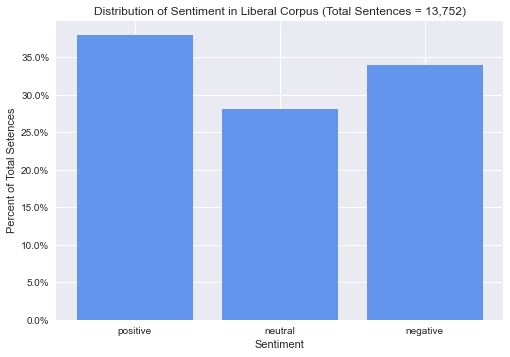

In [63]:
#plot the liberal sentiment analysis distribution
plot_sentiment_dist(positive_sentences_liberal, neutral_sentences_liberal, negative_sentences_liberal, "cornflowerblue",'Distribution of Sentiment in Liberal Corpus')

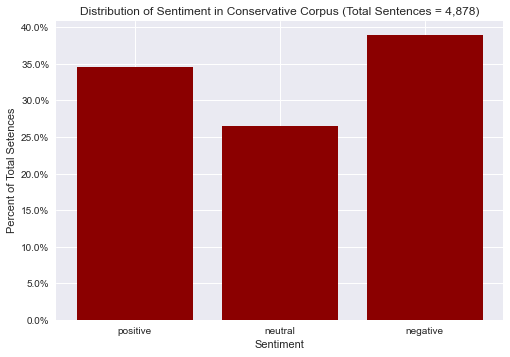

In [64]:
#plot the conservative sentiment analysis distribution
plot_sentiment_dist(positive_sentences_conservative, neutral_sentences_conservative, negative_sentences_conservative, "darkred", 'Distribution of Sentiment in Conservative Corpus')

# Policy Implications

**INSERT SOMETHING HERE ABOUT POLICY IMPLICATIONS**
1. LALALA
2. OOHH LOOK AT MEEEEE, I'M POLICY RELATED

# Future Work & Analysis Limitations

**Future Work**
1. Look at transcripts of **local news channels** instead of national news channels to get a better approximation of localized opinions about COVID-19 and its associated mitigation strategies
    - This matches the way that COVID-19 mitigation is being addressed now – on a case by case, local level
2. Expand to look at more **change over time** in the coverage of COVID-19 under different presidential administrations instead of lumping them together to see how the discussion of the pandemic has changed over time

**Limitation**
1. By just doing text analysis, the **context** and **tone** surrounding the words is absent
    - We found that the words used across the liberal and conservative news channels is the same but the context in which its being used or the tone with which the words are used could be different (and meaningfully so) but this is unable to be captured through only text analysis